In [1]:
using Distributions

First we'll make some data, and try to see how well the regression recovers the parameters.

In [2]:
# Generate some data

a = 0.45
b = 4.2

n_samples = 20

xs = zeros(n_samples)
ys = zeros(n_samples)

for i in 1:n_samples
    x = rand(Normal())
    xs[i] = x
    ys[i] = a * x + b + rand(Normal(0, 0.5))
end

In [3]:
using Plots

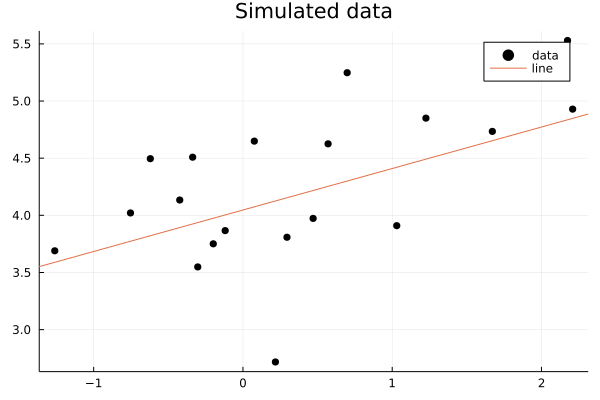

In [52]:
p = scatter(xs, ys, label="data", color="black", title="Simulated data")

Plots.abline!(p, a, b, label="line")

In [53]:
savefig(p, "figures/linear_data.pdf")

# Frequentist model

We'll try to fit a small model, in frequentist and bayesian case.

In [8]:
using GLM

In [9]:
using DataFrames

In [10]:
dataframe = DataFrame(:x => xs, :y => ys) |> df -> sort(df, :x)

,x,y
,Float64,Float64
1,-1.26077,3.68964
2,-0.753452,4.0208
3,-0.620591,4.49562
4,-0.423427,4.13395
5,-0.33695,4.50861
6,-0.30273,3.54857
7,-0.198774,3.75072
8,-0.118956,3.86627
9,0.0762339,4.64912


In [11]:
lm_freq = lm(@formula(y ~ 1 + x), dataframe)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

y ~ 1 + x

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  4.13264     0.135832  30.42    <1e-16   3.84727    4.41802
x            0.438234    0.129663   3.38    0.0033   0.165823   0.710645
────────────────────────────────────────────────────────────────────────

To look how our model looks, we'll plot predictions.

In [12]:
μ_y = predict(lm_freq, dataframe)

20-element Vector{Union{Missing, Float64}}:
 3.5801306022261294
 3.802454096306109
 3.860678150865918
 3.947082042532428
 3.9849792850391905
 3.999975501665192
 4.0455328804201685
 4.080511879966782
 4.166050475360085
 4.227985854364153
 4.261915758303946
 4.3387127741856375
 4.382644908960813
 4.438679118486512
 4.584233295704217
 4.6699118714115535
 4.864909626164258
 4.869617714679915
 5.085611250190308
 5.100712408208254

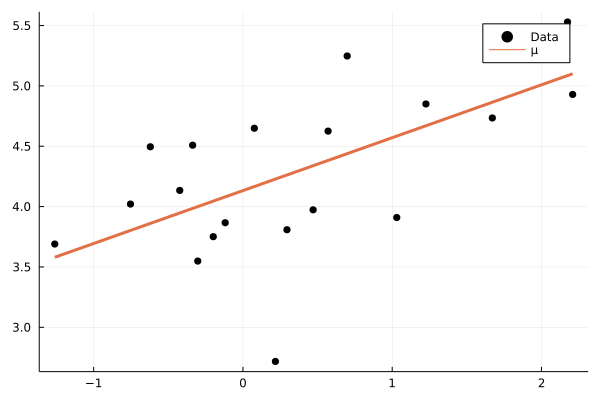

In [13]:
p = scatter(dataframe[!,:x], dataframe[!,:y], label="Data", color="black")
plot!(p, dataframe[!,:x], μ_y, label="μ", w=3)

In [14]:
conf_int = predict(lm_freq, dataframe, interval=:confidence);

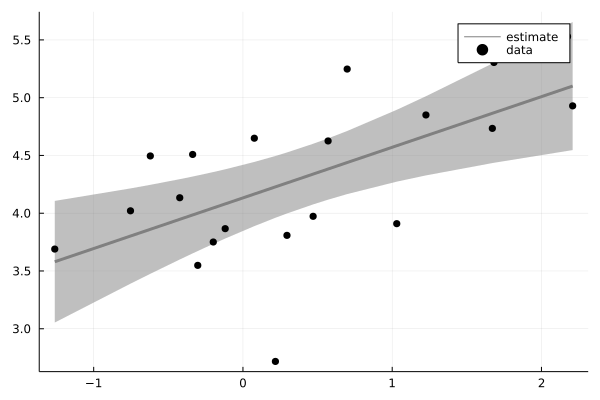

In [15]:
plot(dataframe[!,:x], μ_y, ribbon=(conf_int[!,:upper] .- μ_y,
                                   μ_y .- conf_int[!,:lower]),
     color="grey", label="estimate", w=3)
scatter!(dataframe[!,:x], dataframe[!,:y], label="data", color="black")
# plot!(dataframe[!,:x], conf_int[!,:upper], color="grey", label=missing)
# plot!(dataframe[!,:x], conf_int[!,:lower], color="grey", label=missing)

In [16]:
pred_int = predict(lm_freq, dataframe, interval=:prediction);

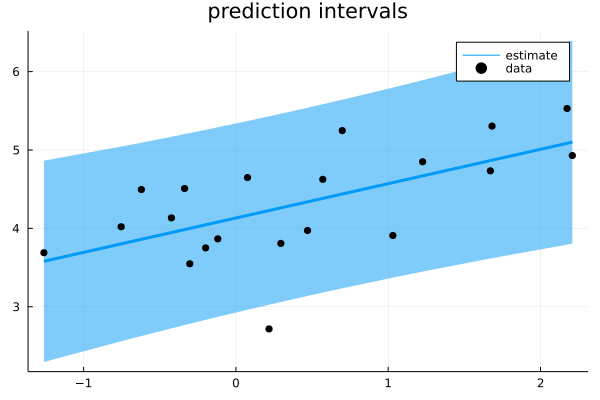

In [54]:
p = plot(dataframe[!,:x], μ_y, ribbon=(pred_int[!,:upper] .- μ_y,
                                       μ_y .- pred_int[!,:lower]),
      label="estimate", title="prediction intervals", w=3)

scatter!(p, dataframe[!,:x], dataframe[!,:y], label="data", color="black")
# plot!(dataframe[!,:x], pred_int[!,:lower], color="green", label=missing)
# plot!(dataframe[!,:x], pred_int[!,:upper], color="green", label=missing)

In [55]:
savefig(p, "figures/linear_prediction_interval.pdf")

We can see that the *prediction intervals* include the error around the line. But do they include the error *in* the lines (that we see the confidence intervals have different widths!)

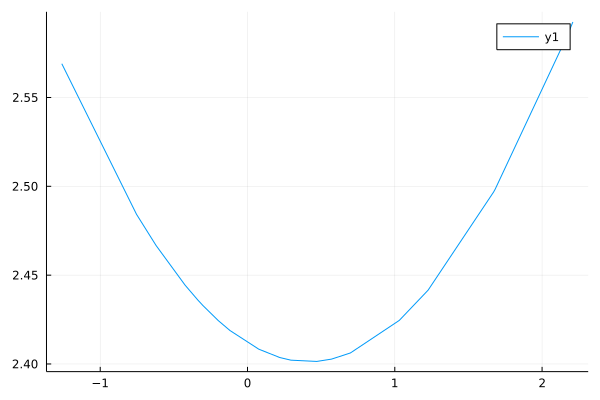

In [19]:
plot(dataframe[!,:x], pred_int[!,:upper] .- pred_int[!,:lower])

The answer is yes. They also include the uncertainty as to where the line is!

# Bayesian model

In [20]:
using Turing

In [21]:
@model function linear(xs, ys)
    l = length(xs)
    
    # Priors for lines
    a ~ Normal(0, 1)
    b ~ Normal(0, 3)
    
    # Prior for variance of points with line
    sigma ~ Exponential(0.2)
    
    for i in 1:l
        expected = a * xs[i] + b
        ys[i] ~ Normal(expected, sigma)
    end
    
    return ys
end

linear (generic function with 2 methods)

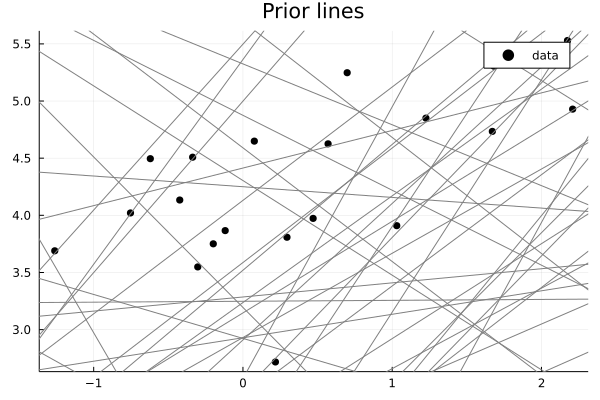

In [22]:
# Sampling from prior

N = 100
as = rand(Normal(0, 1), N)
bs = rand(Normal(0, 3), N)

p = scatter(dataframe[!,:x], dataframe[!,:y], label="data", title="Prior lines",
    color="black")
for i in 1:N
    Plots.abline!(p, as[i], bs[i], label=missing, color="gray")
end

p

In [23]:
savefig(p, "figures/linear_prior_lines.pdf")

In [24]:
model = linear(xs, ys)
chain = sample(model, NUTS(0.65), 2000)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/noric/.julia/packages/Turing/Tpj0b/src/inference/hmc.jl:188
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (2000×15×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 13.88 seconds
Compute duration  = 13.88 seconds
parameters        = a, b, sigma
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           a    0.4349    0.1271     0.0028    0.0029   1871.8784    0.9996    ⋯
           b    4.1248    0.1271     0.0028    0.0029   1933.1311    0.9995    ⋯
       sigma    0.5481    0.0860     0.0019    0.0018   1678.1433    1.0016    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75

In [25]:
using StatsPlots

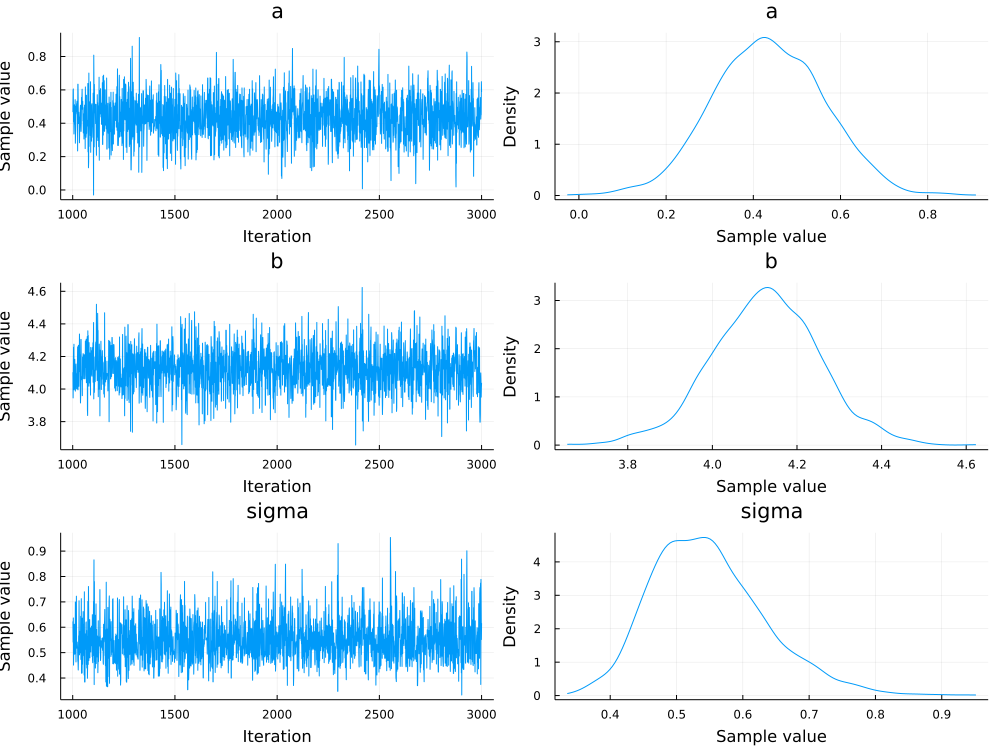

In [26]:
plot(chain)

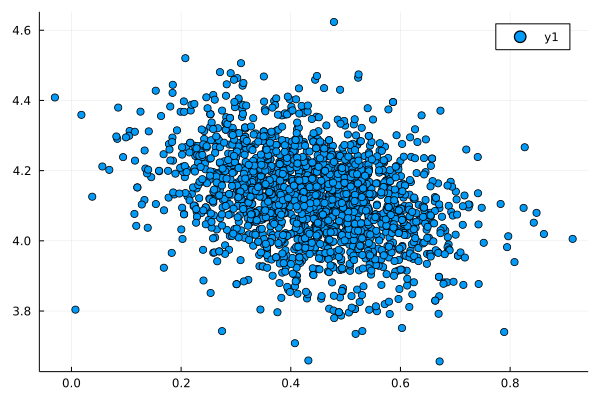

In [56]:
scatter(chain[:a], chain[:b])

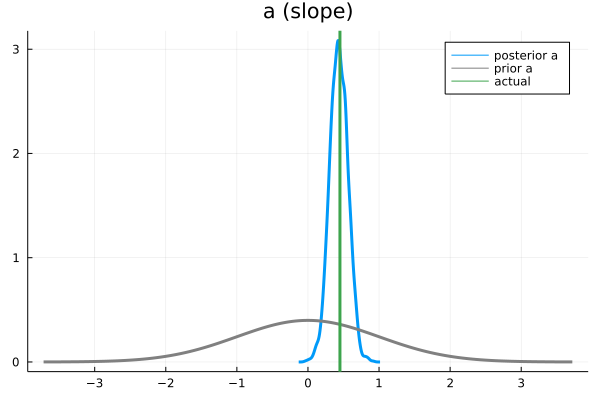

In [36]:
p_a = density(chain[:a], label="posterior a", title="a (slope)", w=3)

plot!(p_a, Normal(0, 1), label="prior a", color="gray", w=3)
vline!(p_a, [0.45], label="actual", w=3)

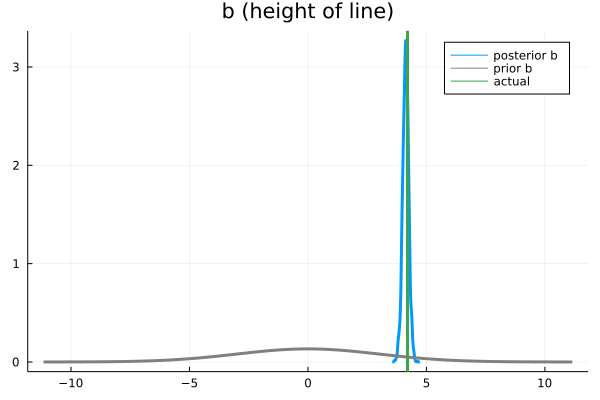

In [35]:
p_b = density(chain[:b], label="posterior b", title="b (height of line)", w=3)
plot!(p_b, Normal(0, 3), label="prior b", color="gray", w=3)
vline!(p_b, [4.2], label="actual", w=3)

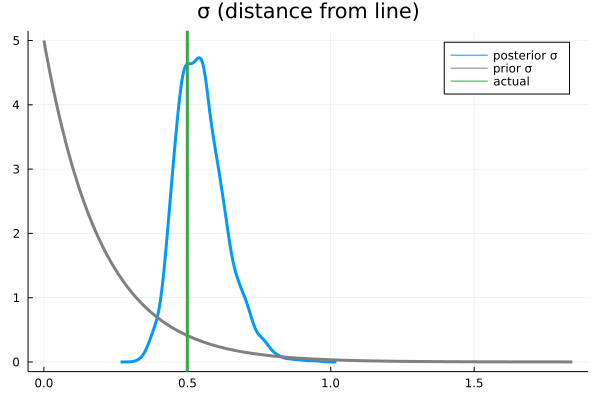

In [40]:
p_σ = density(chain[:sigma], label="posterior σ", title="σ (distance from line)", w=3)

plot!(p_σ, Exponential(0.2), label="prior σ", color="gray", w=3)

vline!(p_σ, [0.5], label="actual", w=3)

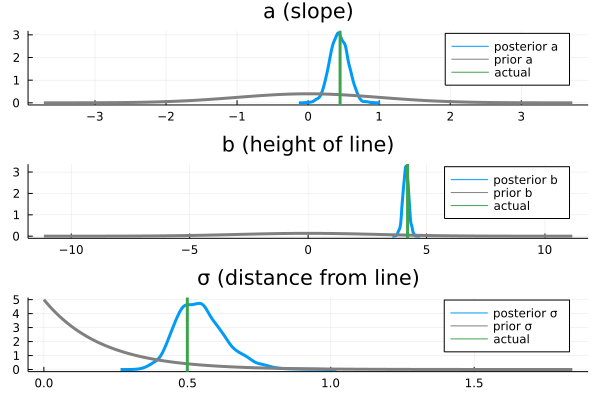

In [41]:
p_posteriors = plot(p_a, p_b, p_σ, layout=(3,1))

In [42]:
savefig(p_posteriors, "figures/posterior_parameters.pdf")

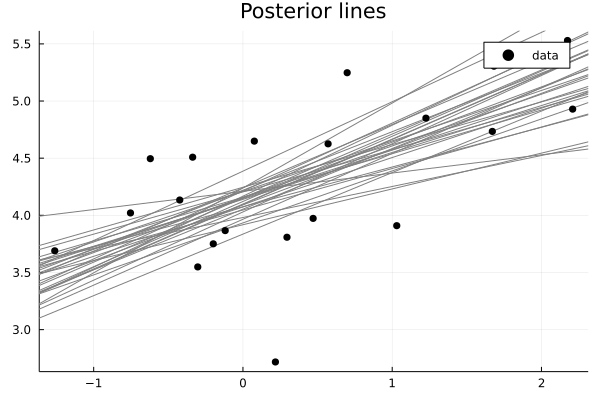

In [43]:
p = plot(title="Posterior lines")

for i in 1:30
    a = rand(chain[:a])
    b = rand(chain[:b])
    
    Plots.abline!(p, a, b,
        label=missing,
        color="gray")
end

scatter!(p, dataframe[!, :x], dataframe[!,:y], color="black", label="data")

p

In [44]:
savefig(p, "figures/posterior_lines.pdf")

We see we get a distribution of many lines, which show the uncertainty. 
Now, how do you make predictions with such a model? 

# Bayesian predictions

In [45]:
# Prediction
model = linear([0.0, 1.0], [missing, missing])

prediction = predict(model, chain)

Chains MCMC chain (2000×2×1 Array{Float64, 3}):

Iterations        = 1:1:2000
Number of chains  = 1
Samples per chain = 2000
parameters        = ys[1], ys[2]
internals         = 

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

       ys[1]    4.0903    0.5682     0.0127    0.0127   2061.0605    0.9996
       ys[2]    4.5545    0.5883     0.0132    0.0142   2147.1821    0.9996

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

       ys[1]    2.9930    3.7083    4.0930    4.4636    5.1717
       ys[2]    3.4211    4.1658    4.5507    4.9388    5.7027


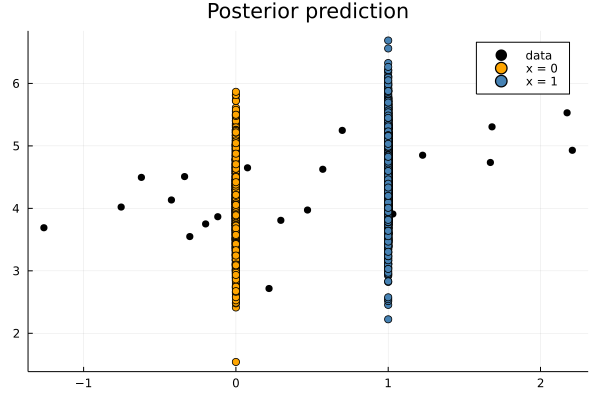

In [46]:
p = scatter(dataframe[!, :x], dataframe[!,:y], color="black", label="data",
    title="Posterior prediction")

scatter!(repeat([0.0], 2000), prediction["ys[1]"], label="x = 0", color="orange")
scatter!(repeat([1.0], 2000), prediction["ys[2]"], label="x = 1", color="steelblue")

In [47]:
savefig(p, "figures/predictions.pdf")

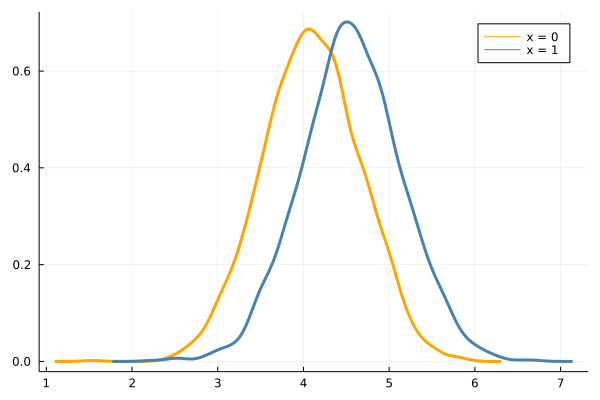

In [48]:
p_predictions = density(prediction["ys[1]"], label="x = 0", color="orange", w=3)
density!(p_predictions, prediction["ys[2]"], label="x = 1", color="steelblue", w=3)

In [49]:
savefig(p_predictions, "figures/prediction_distrubtions.pdf")

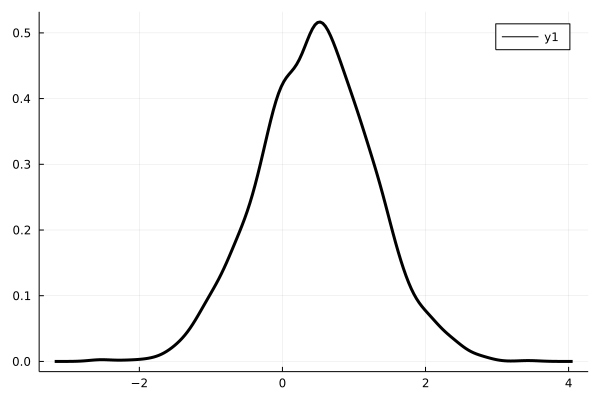

In [50]:
p = density(prediction["ys[2]"] .- prediction["ys[1]"], color="black", w=3)

In [51]:
savefig(p, "figures/prediction_difference.pdf")